In [1]:
import os
import re
import cv2
import bm3d
import pickle
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte
from tqdm.auto import tqdm
from PIL import Image
import numpy as np
import ssim
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matlab.engine
eng = matlab.engine.start_matlab()

In [2]:
eng.cd(r'FastEMD', nargout=0)
eng.compile_FastEMD(nargout=0)
eng.cd(r'..', nargout=0)
eng.path_file(nargout=0)

(-0.5, 511.5, 511.5, -0.5)

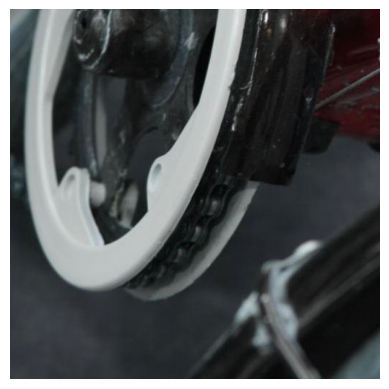

In [3]:
gt = cv2.imread('../PolyU/CroppedImages\Canon5D2_5_160_6400_bicycle_6_mean.JPG')
gt_img = Image.fromarray(gt, 'RGB')
gt_norm = gt.astype('float64') / 255.0
plt.imshow(gt_norm)
plt.axis('off')

1.0 0.0


(-0.5, 511.5, 511.5, -0.5)

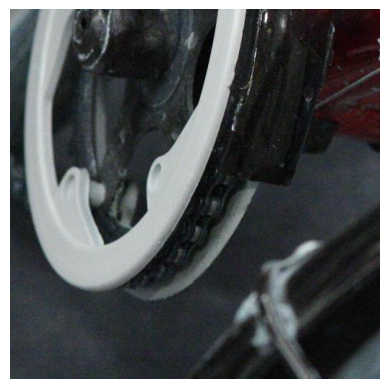

In [4]:
noisy = cv2.imread('../PolyU/CroppedImages\Canon5D2_5_160_6400_bicycle_6_real.JPG')
noisy_img = Image.fromarray(noisy, 'RGB')
noisy_norm = noisy.astype('float64') / 255.0
print(np.max(noisy_norm), np.min(noisy_norm))
plt.imshow(noisy_norm)
plt.axis('off')

In [5]:
noise_psnr = peak_signal_noise_ratio(gt_norm, noisy_norm)
noise_ssim = structural_similarity(gt_norm, noisy_norm, data_range=noisy_norm.max() - noisy_norm.min(), channel_axis=2)
noise_cw = ssim.SSIM(gt_img).cw_ssim_value(noisy_img)
noise_unique = eng.unique_iqa(gt, noisy)
noise_msunique = eng.msunique(gt, noisy)
noise_csv = eng.csv(gt, noisy)
noise_summer = eng.SUMMER(gt, noisy)
print(noise_psnr)
print(noise_ssim)
print(noise_cw)
print(noise_unique)
print(noise_msunique)
print(noise_csv)
print(noise_summer)

33.201269139793865
0.870816448075391
0.9775960562973797
0.582680270361809
0.8037040036622581
0.984046486604949
4.156481918321771


In [6]:
def denoise_nlm(img):
    sigma_est = np.mean(estimate_sigma(img, channel_axis=2))
    denoise_img = denoise_nl_means(img, h= 15 * sigma_est, fast_mode=False,
                               patch_size=5, patch_distance=3, channel_axis=2)
    return denoise_img

34.92713945839729
0.9535743065850882
0.988320002211179
0.7865319765971882
0.8935798466923394
0.9879042790808824
4.212199768389276


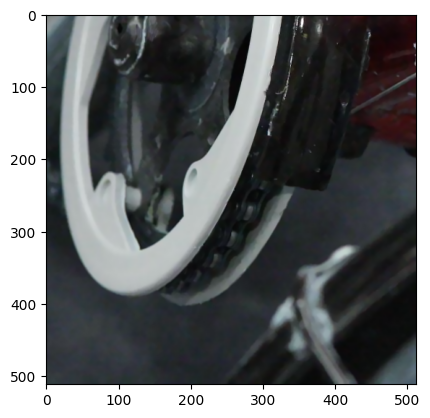

In [8]:
# sig = np.mean(estimate_sigma(noisy_norm, channel_axis=2))
# denoised = np.clip(bm3d.bm3d(noisy_norm, sigma_psd=15*sig, stage_arg=bm3d.BM3DStages.ALL_STAGES), 0.0, 1.0)
denoised = np.clip(denoise_nlm(noisy_norm), 0.0, 1.0)
denoised_img = Image.fromarray(img_as_ubyte(denoised), 'RGB')
noise_psnr = peak_signal_noise_ratio(gt_norm, denoised)
noise_ssim = structural_similarity(gt_norm, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
noise_cw = ssim.SSIM(gt_img).cw_ssim_value(denoised_img)
denoised = np.ascontiguousarray(img_as_ubyte(denoised))
noise_unique = eng.unique_iqa(gt, denoised)
noise_msunique = eng.msunique(gt, denoised)
noise_csv = eng.csv(gt, denoised)
noise_summer = eng.SUMMER(gt, denoised)
print(noise_psnr)
print(noise_ssim)
print(noise_cw)
print(noise_unique)
print(noise_msunique)
print(noise_csv)
print(noise_summer)
plt.imshow(denoised)

In [ ]:
def find_image_pairs(directory):
    file_pattern = re.compile(r'^(.*)_(mean|real)\.JPG$')
    images = {}
    for filename in os.listdir(directory):
        match = file_pattern.match(filename)
        if match:
            key = match.group(1)
            image_type = match.group(2)
            images.setdefault(key, {})[image_type] = filename
    return [(os.path.join(directory, pair['mean']), os.path.join(directory, pair['real'])) 
            for pair in images.values() if 'mean' in pair and 'real' in pair]

img_pairs = find_image_pairs('../PolyU/CroppedImages')
print(img_pairs)

In [ ]:
def IQA_dict(directory):
    file_pattern = re.compile(r'^(.*?)(?:_mean|_real)\.JPG$')
    image_dict = {}
    for filename in os.listdir(directory):
        match = file_pattern.match(filename)
        if match:
            key = match.group(1)
            image_dict[key] = []
    return image_dict

iqa_file = IQA_dict('../PolyU/CroppedImages')
print(iqa_file)

In [ ]:
psnr_diff = []
ssim_diff = []
cw_diff = []
u_diff = []
msu_diff = []
csv_diff = []
summer_diff = []

for mean, real in tqdm(img_pairs):
    gt = cv2.imread(mean)
    gt_img = Image.fromarray(gt, 'RGB')
    gt_norm = gt.astype('float64') / 255.0
    noisy = cv2.imread(real)
    noisy_img = Image.fromarray(noisy, 'RGB')
    noisy_norm = noisy.astype('float64') / 255.0

    noise_psnr = peak_signal_noise_ratio(gt_norm, noisy_norm)
    noise_ssim = structural_similarity(gt_norm, noisy_norm, data_range=noisy_norm.max() - noisy_norm.min(), channel_axis=2)
    noise_cw = ssim.SSIM(gt_img).cw_ssim_value(noisy_img)
    noise_u = eng.unique_iqa(gt, noisy)
    noise_msu = eng.msunique(gt, noisy)
    noise_csv = eng.csv(gt, noisy)
    noise_summer = eng.SUMMER(gt, noisy)

    # sig = np.mean(estimate_sigma(noisy_norm, channel_axis=2))
    # denoised = np.clip(bm3d.bm3d(noisy_norm, sigma_psd=15*sig, stage_arg=bm3d.BM3DStages.ALL_STAGES), 0.0, 1.0)
    denoised = np.clip(denoise_nlm(noisy_norm), 0.0, 1.0)
    denoised_img = Image.fromarray(img_as_ubyte(denoised), 'RGB')
    denoise_psnr = peak_signal_noise_ratio(gt_norm, denoised)
    denoise_ssim = structural_similarity(gt_norm, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
    denoise_cw = ssim.SSIM(gt_img).cw_ssim_value(denoised_img)
    denoised = np.ascontiguousarray(img_as_ubyte(denoised))
    denoise_u = eng.unique_iqa(gt, denoised)
    denoise_msu = eng.msunique(gt, denoised)
    denoise_csv = eng.csv(gt, denoised)
    denoise_summer = eng.SUMMER(gt, denoised)

    iqa = {"Noise": (noise_psnr, noise_ssim, noise_cw, noise_u, noise_msu, noise_csv, noise_summer),"Denoise": (denoise_psnr,denoise_ssim, denoise_cw, denoise_u, denoise_msu, denoise_csv, denoise_summer)}
    img = (mean.split("\\")[-1]).split(".")[0]
    img = "_".join(img.split("_", 6)[:6])
    print(iqa)
    iqa_file[img].append(iqa)
        
    psnr_diff.append(denoise_psnr - noise_psnr)
    ssim_diff.append(denoise_ssim - noise_ssim)
    cw_diff.append(denoise_cw - noise_cw)
    u_diff.append(denoise_u - noise_u)
    msu_diff.append(denoise_msu - noise_msu)
    csv_diff.append(denoise_csv - noise_csv)
    summer_diff.append(denoise_summer - noise_summer)

In [ ]:
psnr_diff, ssim_diff, cw_diff, u_diff, msu_diff, csv_diff, summer_diff = np.array(psnr_diff), np.array(ssim_diff), np.array(cw_diff), np.array(u_diff), np.array(msu_diff), np.array(csv_diff), np.array(summer_diff)
min_max_mean = {"Min": [np.min(psnr_diff), np.min(ssim_diff), np.min(cw_diff), np.min(u_diff), np.min(msu_diff), np.min(csv_diff), np.min(summer_diff)], "Max": [np.max(psnr_diff), np.max(ssim_diff), np.max(cw_diff), np.max(u_diff), np.max(msu_diff), np.max(csv_diff), np.max(summer_diff)], "Mean": [np.mean(psnr_diff), np.mean(ssim_diff), np.mean(cw_diff), np.mean(u_diff), np.mean(msu_diff), np.mean(csv_diff), np.mean(summer_diff)]}
print(min_max_mean)

In [ ]:
print(iqa_file)

In [ ]:
with open('IQA_PolyU/iqa_PolyU_nlm.pkl', 'wb') as fp:
    pickle.dump(iqa_file, fp)
    print('saved successfully')

with open('IQA_PolyU/iqa_PolyU_nlm_infer.pkl', 'wb') as fp:
    pickle.dump(min_max_mean, fp)   
    print('saved successfully')

In [ ]:
with open('IQA_PolyU/iqa_PolyU_nlm.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print(iqa)

In [ ]:
with open('IQA_PolyU/iqa_PolyU_nlm_infer.pkl', 'rb') as fp:
  inference = pickle.load(fp)
  print(inference)